# DTSA 5011: Convolutional Neural Network Project

## Dataset Description and Project Purpose:

The purpose of this Kaggle project is to use CNN techniques to accurately identify malignant tissue from sentinel lymph node pathohistology images. The dataset contains 327,680 patch images obtained from 400 different histology slides. All of the pathohistology slides were obtained from sentinel lymph node biopsies which are used to detect if a cancer has become malignant. (The data is originally from the PatchCamelyon (PCam) dataset, however, was modified to remove duplicate images.)

### Dataset Citations:

```
@inproceedings{veeling2018rotation,
  title={Rotation equivariant CNNs for digital pathology},
  author={Veeling, Bastiaan S and Linmans, Jasper and Winkens, Jim and Cohen, Taco and Welling, Max},
  booktitle={International Conference on Medical Image Computing and Computer-Assisted Intervention},
  pages={210--218},
  year={2018},
  organization={Springer}
}

@misc{histopathologic-cancer-detection,
  author = {Will Cukierski},
  title = {Histopathologic Cancer Detection},
  year = {2018},
  howpublished = {\url{https://kaggle.com/competitions/histopathologic-cancer-detection}},
  note = {Kaggle}
}
```

## Import Packages

In [2]:
# Core data handling
import os
import pandas as pd
import numpy as np
import random
import zipfile

# Image handling and visualization
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow/Keras for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Scikit-learn for data splitting
from sklearn.model_selection import train_test_split

# Progress bar
from tqdm import tqdm

# Display settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

## Download and Extract Kaggle Dataset

In [3]:
# Set the API token
os.environ['KAGGLE_API_TOKEN'] = 'KGAT_8069c4badb6ddf090ee981151055bcfb'

# Install/upgrade kaggle
!pip install -q --upgrade kaggle

# Test the connection
print("✓ Testing API connection...")
!kaggle competitions list | head -5

# Download competition data
print("\n✓ Downloading competition data (this may take a few minutes)...")
!kaggle competitions download -c histopathologic-cancer-detection -p /content

# Check if download worked
print("\n✓ Checking for downloaded files...")
!ls -lh /content/*.zip

# Unzip
print("\n✓ Extracting files...")
!cd /content && unzip -q '*.zip'

# Verify
print("\n✓ Final check:")
!ls /content/
!ls /content/train | head -5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 137.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 20.2 MB/s eta 0:00:00
✓ Testing API connection...
ref                                                                              deadline             category          reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3    2026-04-15 23:59:00  Featured   2,207,152 Usd        593           False  
https://www.kaggle.com/c

## Exploratory Data Analysis

In [4]:
# Check how many images we have
print(f"Training images: {len(os.listdir('/content/train'))}")
print(f"Test images: {len(os.listdir('/content/test'))}")

# Load the labels
train_labels = pd.read_csv('/content/train_labels.csv')
print(f"\nLabels shape: {train_labels.shape}")
print(f"\nFirst few rows:")
print(train_labels.head())
print(f"\nLabel distribution:")
print(train_labels['label'].value_counts())
print(f"\nPercentage with cancer: {train_labels['label'].mean()*100:.2f}%")

Training images: 220025
Test images: 57458

Labels shape: (220025, 2)

First few rows:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64

Percentage with cancer: 40.50%


In [5]:
# Dataset Overview
print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Total training images: {len(train_labels)}")
print(f"\nLabel distribution:")
print(train_labels['label'].value_counts())
print(f"\nClass balance:")
print(train_labels['label'].value_counts(normalize=True))
print(f"\nPercentage with cancer (label=1): {train_labels['label'].mean()*100:.2f}%")

DATASET OVERVIEW
Total training images: 220025

Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64

Class balance:
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64

Percentage with cancer (label=1): 40.50%


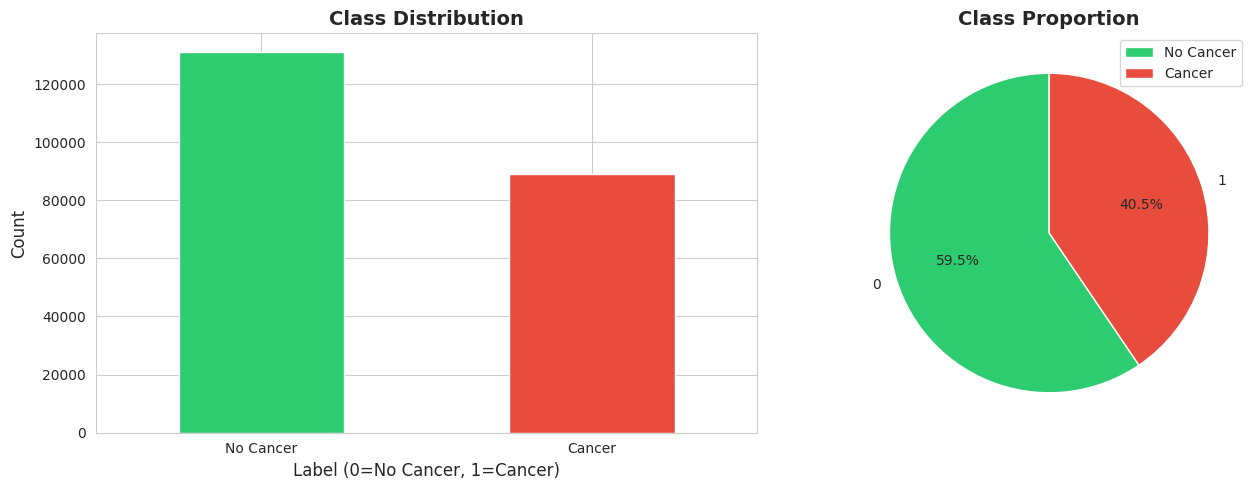

In [6]:
# Visualize Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
train_labels['label'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label (0=No Cancer, 1=Cancer)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['No Cancer', 'Cancer'], rotation=0)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
train_labels['label'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                          colors=colors, startangle=90)
axes[1].set_ylabel('')
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')
axes[1].legend(['No Cancer', 'Cancer'])

plt.tight_layout()
plt.show()

In [7]:
# Check Image Properties
print("\n" + "=" * 50)
print("IMAGE PROPERTIES")
print("=" * 50)

train_dir = '/content/train/'
sample_images = random.sample(os.listdir(train_dir), min(100, len(os.listdir(train_dir))))

widths, heights, channels = [], [], []
for img_name in sample_images:
    img_path = os.path.join(train_dir, img_name)
    img = Image.open(img_path)
    widths.append(img.width)
    heights.append(img.height)
    if img.mode == 'RGB':
        channels.append(3)
    elif img.mode == 'L':
        channels.append(1)

print(f"Image dimensions (from {len(sample_images)} samples):")
print(f"Width: {np.mean(widths):.0f} x Height: {np.mean(heights):.0f}")
print(f"Channels: {np.unique(channels)}")
print(f"Image format: {img.format}")


IMAGE PROPERTIES
Image dimensions (from 100 samples):
Width: 96 x Height: 96
Channels: [3]
Image format: TIFF



SAMPLE IMAGES


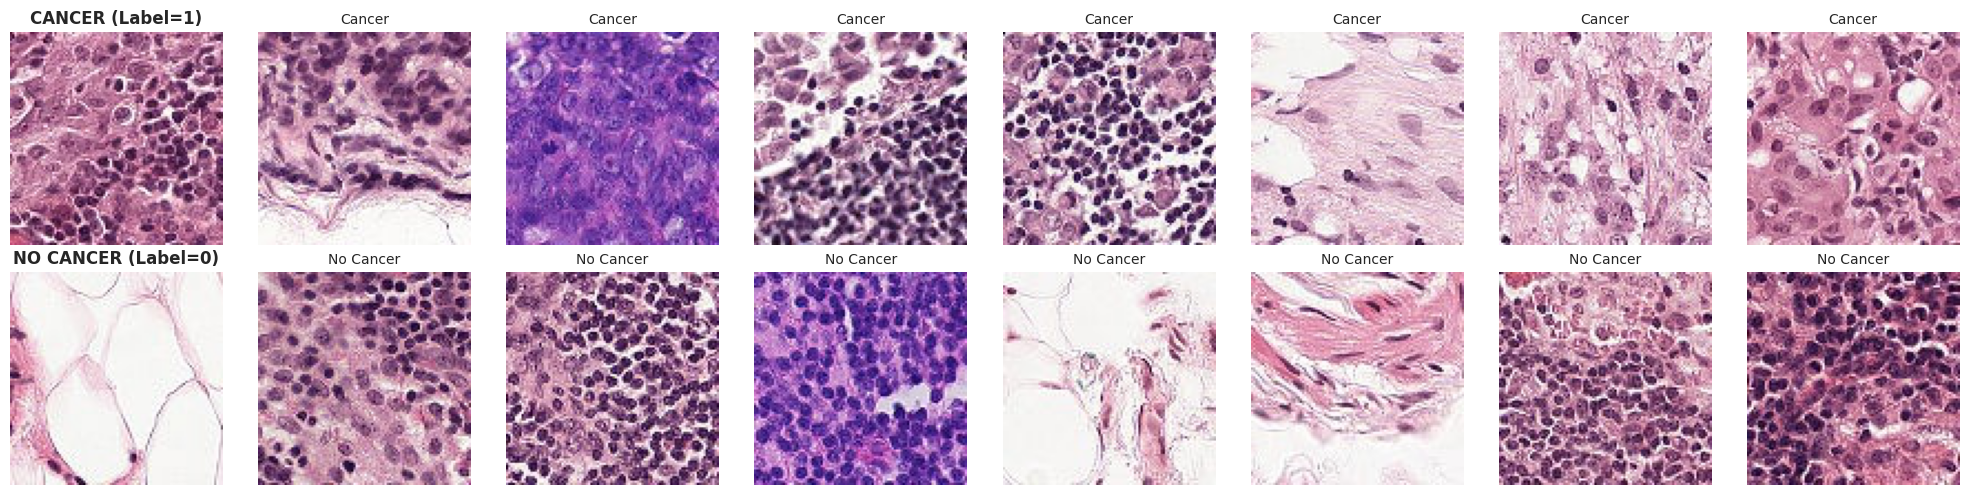

In [8]:
# Visualize Sample Images
print("\n" + "=" * 50)
print("SAMPLE IMAGES")
print("=" * 50)

# Get samples from each class
cancer_ids = train_labels[train_labels['label'] == 1]['id'].values
no_cancer_ids = train_labels[train_labels['label'] == 0]['id'].values

n_samples = 8
cancer_samples = random.sample(list(cancer_ids), n_samples)
no_cancer_samples = random.sample(list(no_cancer_ids), n_samples)

fig, axes = plt.subplots(2, n_samples, figsize=(20, 5))

# Plot cancer images
for i, img_id in enumerate(cancer_samples):
    img_path = os.path.join(train_dir, f"{img_id}.tif")
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('CANCER (Label=1)', fontsize=12, fontweight='bold')
    else:
        axes[0, i].set_title('Cancer', fontsize=10)

# Plot no cancer images
for i, img_id in enumerate(no_cancer_samples):
    img_path = os.path.join(train_dir, f"{img_id}.tif")
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('NO CANCER (Label=0)', fontsize=12, fontweight='bold')
    else:
        axes[1, i].set_title('No Cancer', fontsize=10)

plt.tight_layout()
plt.show()


PIXEL INTENSITY ANALYSIS


/tmp/ipython-input-2668775281.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Cancer', 'No Cancer'], patch_artist=True,


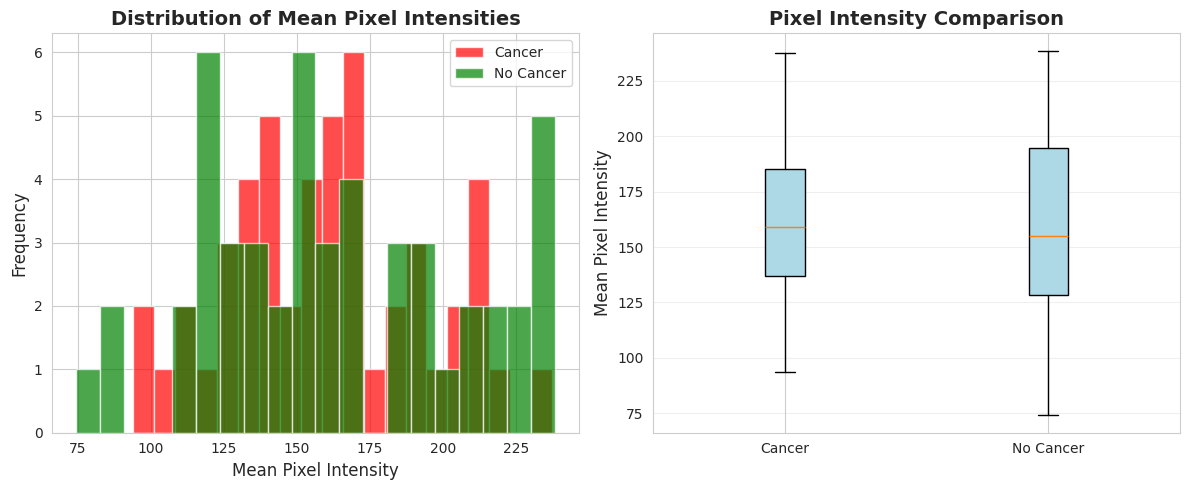


Cancer images - Mean intensity: 160.37 ± 33.86
No cancer images - Mean intensity: 162.47 ± 43.02


In [9]:
# Pixel Intensity Analysis
print("\n" + "=" * 50)
print("PIXEL INTENSITY ANALYSIS")
print("=" * 50)

n_analyze = 50
cancer_intensities = []
no_cancer_intensities = []

cancer_sample_ids = random.sample(list(cancer_ids), n_analyze)
no_cancer_sample_ids = random.sample(list(no_cancer_ids), n_analyze)

for img_id in cancer_sample_ids:
    img = np.array(Image.open(os.path.join(train_dir, f"{img_id}.tif")))
    cancer_intensities.append(img.mean())

for img_id in no_cancer_sample_ids:
    img = np.array(Image.open(os.path.join(train_dir, f"{img_id}.tif")))
    no_cancer_intensities.append(img.mean())

# Plot intensity distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(cancer_intensities, bins=20, alpha=0.7, color='red', label='Cancer')
plt.hist(no_cancer_intensities, bins=20, alpha=0.7, color='green', label='No Cancer')
plt.xlabel('Mean Pixel Intensity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Mean Pixel Intensities', fontsize=14, fontweight='bold')
plt.legend()

plt.subplot(1, 2, 2)
data_to_plot = [cancer_intensities, no_cancer_intensities]
plt.boxplot(data_to_plot, labels=['Cancer', 'No Cancer'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'))
plt.ylabel('Mean Pixel Intensity', fontsize=12)
plt.title('Pixel Intensity Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCancer images - Mean intensity: {np.mean(cancer_intensities):.2f} ± {np.std(cancer_intensities):.2f}")
print(f"No cancer images - Mean intensity: {np.mean(no_cancer_intensities):.2f} ± {np.std(no_cancer_intensities):.2f}")

In [10]:
# Summary Statistics
print("\n" + "=" * 50)
print("SUMMARY")
print("=" * 50)
print(f"✓ Total images: {len(train_labels)}")
print(f"✓ Image size: {int(np.mean(widths))}x{int(np.mean(heights))} pixels")
print(f"✓ Class imbalance ratio: {train_labels['label'].value_counts()[0]/train_labels['label'].value_counts()[1]:.2f}:1")
print(f"✓ Recommended approach: Use data augmentation and class weighting")
print("=" * 50)


SUMMARY
✓ Total images: 220025
✓ Image size: 96x96 pixels
✓ Class imbalance ratio: 1.47:1
✓ Recommended approach: Use data augmentation and class weighting


## Build and Train CNN Model

In [11]:
# Data Preparation
print("=" * 50)
print("DATA PREPARATION")
print("=" * 50)

# Load labels
train_labels = pd.read_csv('/content/train_labels.csv')
train_labels['id'] = train_labels['id'] + '.tif'  # Add file extension
train_labels['label'] = train_labels['label'].astype(str)  # Convert to string for generator

# Split into train and validation sets
train_df, val_df = train_test_split(
    train_labels,
    test_size=0.2,
    stratify=train_labels['label'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Training class distribution:\n{train_df['label'].value_counts()}")

DATA PREPARATION
Training samples: 176020
Validation samples: 44005
Training class distribution:
label
0    104726
1     71294
Name: count, dtype: int64


In [12]:
# Data Augmentation & Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
batch_size = 32
img_size = (96, 96)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='/content/train/',
    x_col='id',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory='/content/train/',
    x_col='id',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [13]:
# Build CNN Model
print("\n" + "=" * 50)
print("BUILDING CNN MODEL")
print("=" * 50)

model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fourth Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Display model architecture
model.summary()


BUILDING CNN MODEL


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 2,622,657 (10.00 MB)

 Trainable params: 2,620,161 (10.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [15]:
# Setup Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_cancer_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [16]:
# Train Model
print("\n" + "=" * 50)
print("TRAINING MODEL")
print("=" * 50)

epochs = 30

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


TRAINING MODEL


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7975 - auc: 0.8618 - loss: 0.4632
Epoch 1: val_auc improved from -inf to 0.92386, saving model to best_cancer_model.h5


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 532s 94ms/step - accuracy: 0.7976 - auc: 0.8618 - loss: 0.4631 - val_accuracy: 0.8402 - val_auc: 0.9239 - val_loss: 0.4049 - learning_rate: 0.0010
Epoch 2/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8505 - auc: 0.9214 - loss: 0.3475
Epoch 2: val_auc did not improve from 0.92386
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 506s 92ms/step - accuracy: 0.8505 - auc: 0.9214 - loss: 0.3475 - val_accuracy: 0.7949 - val_auc: 0.8947 - val_loss: 0.6064 - learning_rate: 0.0010
Epoch 3/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8715 - auc: 0.9375 - loss: 0.3095
Epoch 3: val_auc did not improve from 0.92386
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 506s 92ms/step - accuracy: 0.8715 - auc: 0.9375 - loss: 0.3095 - val_accuracy: 0.7777 - val_auc: 0.9195 - val_loss: 0.5349 - learning_rate: 0.0010
Epoch 4/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8770 - auc: 0.9421 - loss: 0.2972
Epoch 4: val_auc improved from 0.92386 to 0.94555, saving model t

5501/5501 ━━━━━━━━━━━━━━━━━━━━ 505s 92ms/step - accuracy: 0.8770 - auc: 0.9421 - loss: 0.2972 - val_accuracy: 0.8224 - val_auc: 0.9455 - val_loss: 0.4013 - learning_rate: 0.0010
Epoch 5/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8850 - auc: 0.9477 - loss: 0.2823
Epoch 5: val_auc did not improve from 0.94555
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 504s 92ms/step - accuracy: 0.8850 - auc: 0.9477 - loss: 0.2823 - val_accuracy: 0.7360 - val_auc: 0.8809 - val_loss: 0.8521 - learning_rate: 0.0010
Epoch 6/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8899 - auc: 0.9516 - loss: 0.2711
Epoch 6: val_auc did not improve from 0.94555
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 506s 92ms/step - accuracy: 0.8899 - auc: 0.9516 - loss: 0.2711 - val_accuracy: 0.8802 - val_auc: 0.9431 - val_loss: 0.3142 - learning_rate: 0.0010
Epoch 7/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8947 - auc: 0.9552 - loss: 0.2611
Epoch 7: val_auc did not improve from 0.94555
5501/5501 ━━━━━━━━━

5501/5501 ━━━━━━━━━━━━━━━━━━━━ 505s 92ms/step - accuracy: 0.8993 - auc: 0.9577 - loss: 0.2530 - val_accuracy: 0.8705 - val_auc: 0.9560 - val_loss: 0.3212 - learning_rate: 0.0010
Epoch 9/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9008 - auc: 0.9587 - loss: 0.2497
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_auc did not improve from 0.95596
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 505s 92ms/step - accuracy: 0.9008 - auc: 0.9587 - loss: 0.2497 - val_accuracy: 0.7907 - val_auc: 0.9402 - val_loss: 0.5732 - learning_rate: 0.0010
Epoch 10/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9072 - auc: 0.9635 - loss: 0.2345
Epoch 10: val_auc improved from 0.95596 to 0.96412, saving model to best_cancer_model.h5


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 504s 92ms/step - accuracy: 0.9072 - auc: 0.9635 - loss: 0.2345 - val_accuracy: 0.8867 - val_auc: 0.9641 - val_loss: 0.2979 - learning_rate: 5.0000e-04
Epoch 11/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9102 - auc: 0.9656 - loss: 0.2281
Epoch 11: val_auc did not improve from 0.96412
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 506s 92ms/step - accuracy: 0.9102 - auc: 0.9656 - loss: 0.2281 - val_accuracy: 0.8508 - val_auc: 0.9618 - val_loss: 0.3754 - learning_rate: 5.0000e-04
Epoch 12/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9112 - auc: 0.9659 - loss: 0.2262
Epoch 12: val_auc improved from 0.96412 to 0.97739, saving model to best_cancer_model.h5


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 504s 92ms/step - accuracy: 0.9112 - auc: 0.9659 - loss: 0.2262 - val_accuracy: 0.9230 - val_auc: 0.9774 - val_loss: 0.1986 - learning_rate: 5.0000e-04
Epoch 13/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9133 - auc: 0.9678 - loss: 0.2203
Epoch 13: val_auc did not improve from 0.97739
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 504s 92ms/step - accuracy: 0.9133 - auc: 0.9678 - loss: 0.2203 - val_accuracy: 0.8130 - val_auc: 0.9487 - val_loss: 0.5224 - learning_rate: 5.0000e-04
Epoch 14/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9143 - auc: 0.9680 - loss: 0.2200
Epoch 14: val_auc did not improve from 0.97739
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 506s 92ms/step - accuracy: 0.9143 - auc: 0.9680 - loss: 0.2200 - val_accuracy: 0.9202 - val_auc: 0.9733 - val_loss: 0.2155 - learning_rate: 5.0000e-04
Epoch 15/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9176 - auc: 0.9686 - loss: 0.2163
Epoch 15: ReduceLROnPlateau reducing learning ra

## Visualize Training Results


TRAINING RESULTS


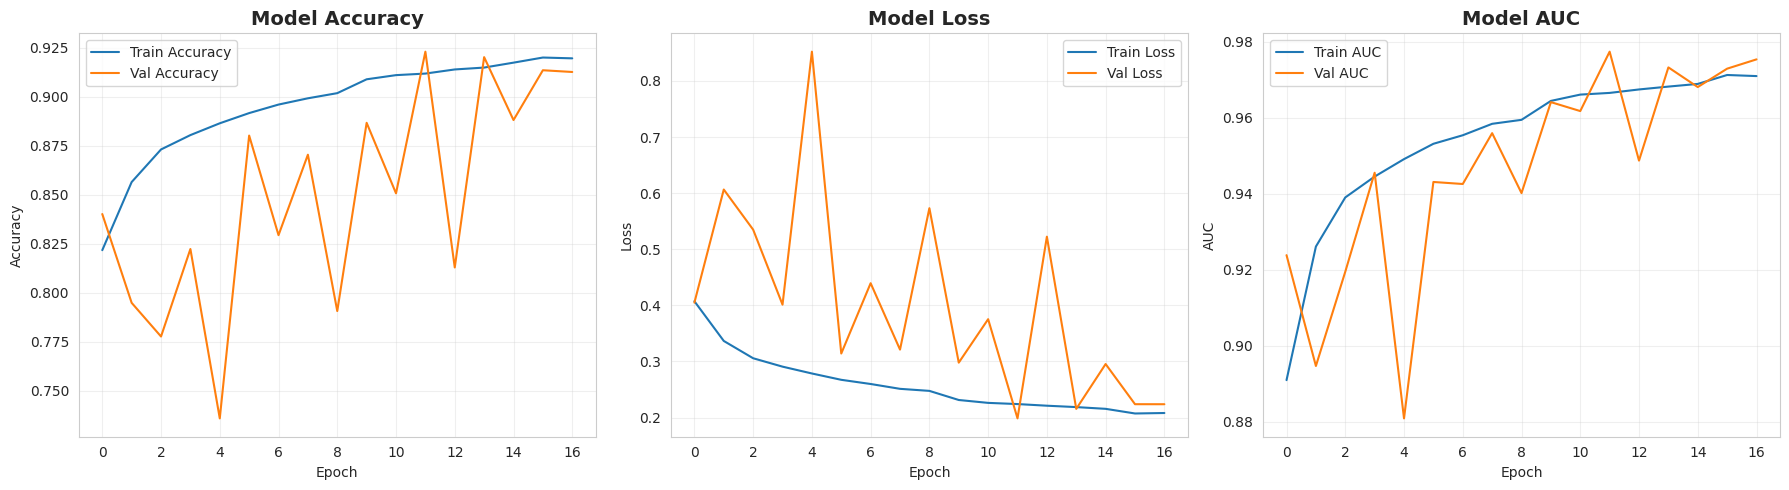


Best Validation Accuracy: 0.9230
Best Validation AUC: 0.9774
Final Training Accuracy: 0.9196
Final Validation Accuracy: 0.9127


In [17]:
# Plot Training History
print("\n" + "=" * 50)
print("TRAINING RESULTS")
print("=" * 50)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC plot
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Val AUC')
axes[2].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print(f"\nBest Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best Validation AUC: {max(history.history['val_auc']):.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [18]:
# Final Evaluation
print("\n" + "=" * 50)
print("FINAL EVALUATION")
print("=" * 50)

val_loss, val_acc, val_auc = model.evaluate(val_generator, verbose=1)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation AUC: {val_auc:.4f}")


FINAL EVALUATION
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.9216 - auc: 0.9772 - loss: 0.2003

Validation Loss: 0.1986
Validation Accuracy: 0.9230
Validation AUC: 0.9774


## Model Discussion

### Model Overview:

The CNN model above learns how to accurately differentiate cancerous tissue from non-cancerous tissue through a series of deep learning techniques. The first deep learning method used is known as convolution blocks. In the model above, I included four different convolution blocks. Each one utilized 3x3 kernels to review each image and start to recognize specific histology features. I doubled the number of features for each subsequent block so that the model could start with learning broader patterns in the images and then start to hone in on identifying small details in the histology slides.
I used a ReLU activation function for the hidden middle layers and a sigmoid activation function for the final layer. ReLU is an efficient activation function that changes all negative input to 0, and keeps all positive input. The sigmoid activation function was perfect for this model because it allows for binary classification (cancerous vs. not cancerous tissue). The sigmoid activation function is also perfect for the final output function since it can give confidence or probability that something is cancer vs. not cancer.
In each convolution layer, I added a batch normalization function, a dropout function, as well as a max pooling function. The batch normalization is added to normalize the output from previous layers. It scales the previous values to 0, with a standard deviation of 1. This normalization allows for faster learning rates and minimizes any extra noise. The max pooling layer helps downscale computational cost, while keeping important features. And the dropout function was added to prevent overfitting. After each convolution block, the dropout function layer randomly drops 25% of the connections to prevent overfitting from occurring from extraneous learning.
After these four convolution blocks I incorporated a flatten function which transitions the data from spatial features to decision making features. All of the learned features were combined via the dense layer function, to make the final decision.
Finally I added the Keras package to the model to finish several important tasks including adding an optimization function to indicate how the algorithm should update weights, how fast it should learn, and what the loss goal should be. I also added early stopping to ensure that the model did not overfit during additional epochs.
Results and Conclusion:
Overall, the model performed exceptionally well! The model achieved a validation accuracy of 92.30% in the best epoch (epoch 12), with a final validation loss of 0.1986 and a validation AUC of 0.9774. A low validation loss indicates that the model is highly accurate at making predictions.
During the first epoch, the training accuracy was less than 80% and the validation accuracy was approximately 84%. This is expected since the model is slowly starting to pick up on general features in the histology images.
In the second epoch there was improvement in training accuracy to 85.05%, while validation accuracy decreased slightly to around 79%, but the validation AUC remained stable at 0.8947.
In the third epoch, training accuracy reached 87.15% while validation performance continued to fluctuate as the model learned patterns.
Epochs four through nine showed steady improvements, with the model continuing to learn more nuanced features. The learning rate was reduced in epoch 9 after the validation loss plateaued, which helped the model fine-tune its weights more carefully.
Epoch 12 showed the best model performance with validation accuracy of 92.30% and validation AUC of 0.9774. This means that after 12 rounds of learning, the model was highly effective at differentiating cancer from non-cancer tissue.
The training continued through epoch 17 when early stopping was triggered. After epoch 12, the model began showing signs of overfitting as training accuracy continued to increase (reaching 91.85%) while validation performance plateaued and then slightly decreased. This is why the early stopping callback restored the weights from epoch 12, ensuring we kept the best-performing model.
Key Performance Metrics (Best Epoch - Epoch 12):

Validation Accuracy: 92.30%
Validation AUC: 0.9774
Validation Loss: 0.1986

These results demonstrate that the CNN architecture with data augmentation, batch normalization, dropout regularization, and early stopping was highly effective for this histopathologic cancer detection task.
